   # TP53: Effects of All Mutations on Interacting Proteins - Visualization

<b>Standard imports for playing with and plotting data frames.</b>

In [66]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns

<b>Import CPTAC data</b>

In [67]:
import CPTAC

In [68]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

In [69]:
gene = 'TP53'
protList = ['TGFB1', 'AXIN1', 'EP300', 'HRMT1L2', 'CARM1', 'TAF1', 'ING4', 'CABLES1', 
            'TP73', 'HIPK1', 'HIPK2', 'TP53INP1', 'TP53BP', 'WWOX', 'HCV', 'USP7', 'SYVN1', 'HSP90AB1',
           'CHD8', 'ARMC10', 'BANP', 'CDKN2AIP', 'NUAK1', 'STK11', 'LKB1', 'UHRF2', 'E4F1', 'YWHAZ',
           'MAML1', 'MKRN1', 'PML', 'MDM2', 'FBXO42', 'ATM', 'PP2R2A', 'AURKA', 'DAXX', 'BRD7', 'TRIM24',
           'L3MBTL1', 'GRK5', 'CAK', 'PTK2B', 'PYK2', 'MDM2', 'PRKCG', 'PPIF', 'KAT6A', 'UBC9', 'ZNF385B',
           'ZNF385A', 'ANKRD2', 'RFFL', 'RNF34', 'MTA1', 'COP1', 'CCAR2', 'MORC3', 'POU4F2', 'AFG1L', 'UBD',
           'TAF6', 'HPV', 'UL123', 'E1B-55K', 'BAX', 'FAS', 'BCL2', 'CREBBP', 'CDK2', 'MDM2', 'CDKN2A', 'ATM',
            'CCNB1', 'TERT', 'IGF1R', 'ALB', 'MMP1', 'TP53']

## t-test for effects of all mutations combined

In [70]:
tested = [];
p_vals = [];
for protein in protList: 
    if protein in proteomics.columns:
        tested.append(protein)
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross[:100]
        cross = cross[["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[cross["Mutation"] != "Wildtype"]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        p_vals.append(ttest[1])

In [71]:
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_vals)[0]
pvals = statsmodels.stats.multitest.fdrcorrection(p_vals)[1]
significant_proteins = np.array(tested)[np.array(areSignificant)]
significant_pvals = np.array(pvals)[np.array(areSignificant)]

In [72]:
print(significant_proteins)
print(significant_pvals)

['CABLES1' 'HSP90AB1' 'CHD8' 'CDKN2AIP' 'STK11' 'YWHAZ' 'AURKA' 'DAXX'
 'PPIF' 'AFG1L' 'FAS' 'CDK2' 'CDKN2A' 'CCNB1' 'TP53']
[2.13179533e-04 1.58064543e-03 1.75627924e-04 6.72159259e-03
 1.46355531e-02 4.07210989e-03 5.41839682e-04 5.41839682e-04
 4.87016600e-02 9.85879464e-03 7.52467214e-06 3.46220063e-03
 3.72695489e-04 4.99108496e-04 4.09191353e-06]


## Figures can easily be generated for each of these proteins and their phosphorylation sites by following the patterns below

## Plot all significant results (including p53 itself)

In [73]:
plotdf = CPTAC.compare_mutations(proteomics, gene)
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation', gene]]
#Append proteomic data for all the proteins to the dataframe with mutational information
for protein in significant_proteins:
    if (protein != gene):
        proteindf = CPTAC.compare_mutations(proteomics, protein, gene)[[protein]]
        plotdf = plotdf.join(proteindf)
        
#Relabel the mutation types for plotting
#plotdf = plotdf.replace({'Mutation': {'Wildtype': 'Control',
                                      #'Missense_Mutation': 'Mutated'}})

plotdf.loc[(plotdf['Mutation'] == "Wildtype"), "Mutation"] = "Control"
plotdf.loc[(plotdf['Mutation'] != "Control"), "Mutation"] = "Mutated"

#Put all proteomic data into one column, with another column giving the protein name, and select for the mutations we want
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Protein', value_name='Proteomics')
plotdf = plotdf.loc[(plotdf['Mutation'] == 'Mutated') | (plotdf['Mutation'] == 'Control')]
plotdf = plotdf.dropna(axis=0)

### Code for generating figure

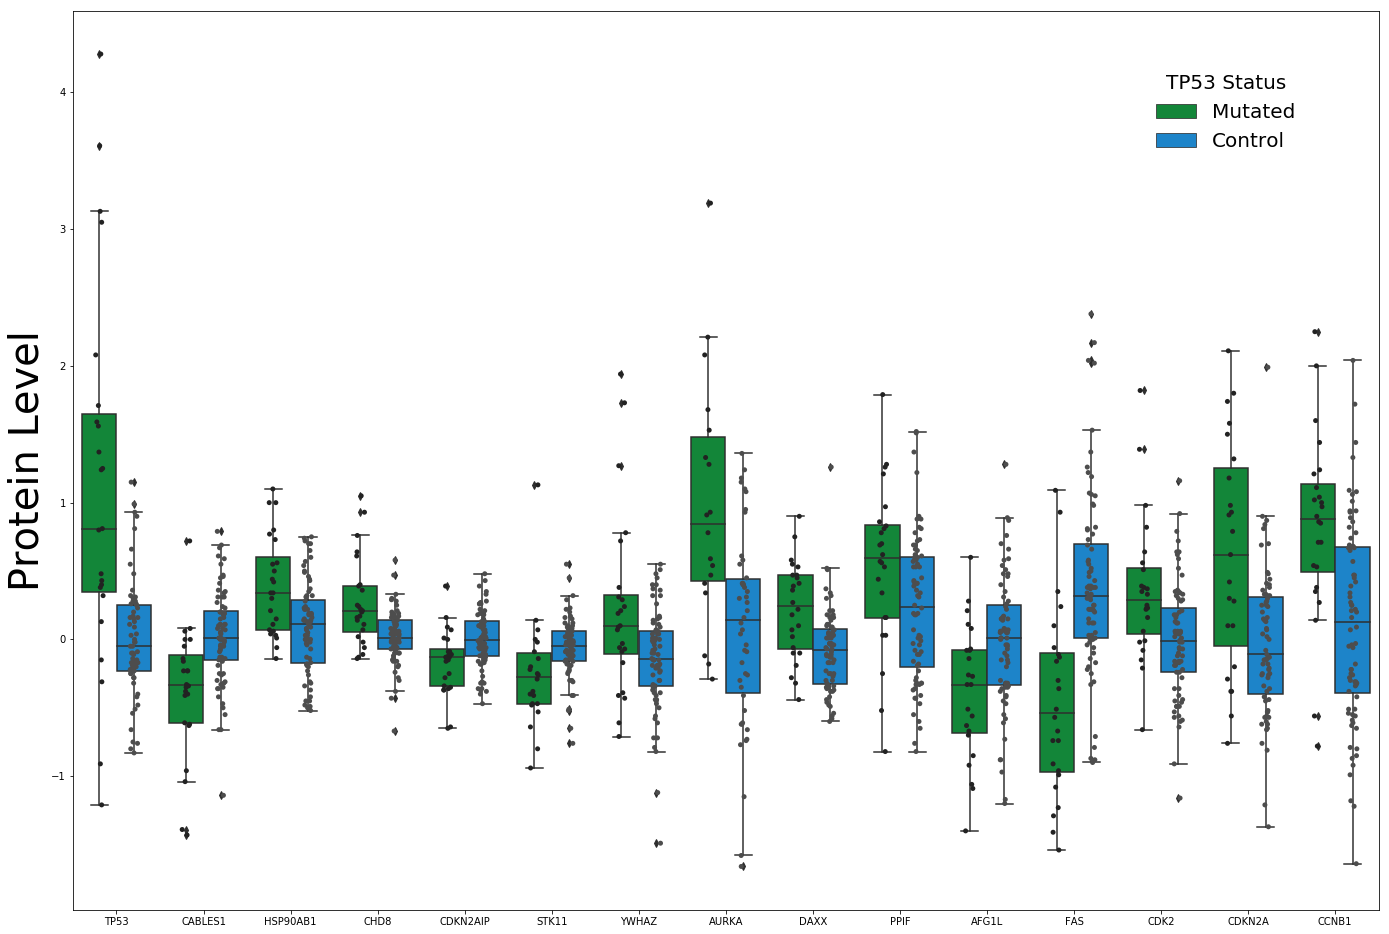

In [74]:
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutated": "#009933", "Control": "#008ae6"}

#Create the plot
boxplt = sns.boxplot(data=plotdf, x='Protein', y='Proteomics', hue='Mutation', palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Protein', y='Proteomics', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Protein Level', fontsize='40')
boxplt.tick_params(labelsize='10')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutated', 'Control'], title='TP53 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
boxplt.get_legend().set_bbox_to_anchor((0.95, 0.95, 0, 0))

## TP53 Mutational Effects on p53

<b>Build dataframe for plotting</b>

In [75]:
proteomicsdf = CPTAC.compare_mutations(proteomics, gene)
proteomicsdf = proteomicsdf.loc[proteomicsdf['Patient_Type'] == 'Tumor'][['Mutation', gene]]

In [76]:
phosdf = CPTAC.compare_mutations(phos, gene)
phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'][['TP53-S315']]

In [77]:
plotdf = proteomicsdf.join(phosdf)
plotdf.loc[(plotdf['Mutation'] == "Wildtype"), "Mutation"] = "Control"
plotdf.loc[(plotdf['Mutation'] != "Control"), "Mutation"] = "Mutated"

plotdf = pd.melt(plotdf, id_vars=['Mutation'], value_vars=['TP53', 'TP53-S315'], var_name='Type', value_name='Reading')
plotdf = plotdf.loc[(plotdf["Mutation"] == "Control") | (plotdf["Mutation"] == "Mutated")]
plotdf = plotdf.dropna(axis=0).sort_values(by=['Mutation'], ascending=False)

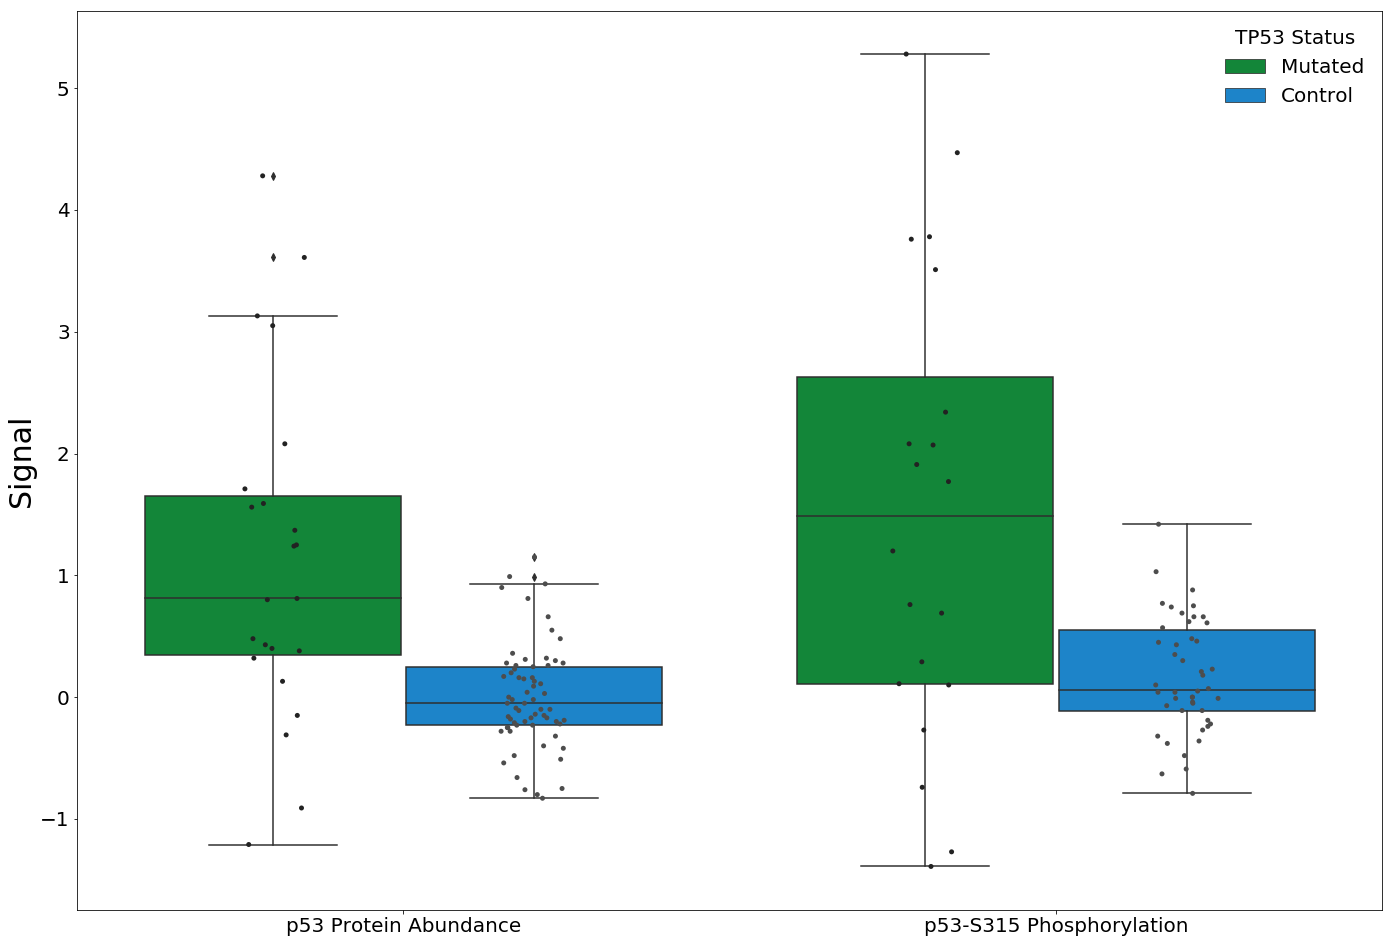

In [78]:
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutated": "#009933", "Control": "#008ae6"}

#Create the plot
boxplt = sns.boxplot(x='Type', y='Reading', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y='Reading', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.set_xticklabels(['p53 Protein Abundance', 'p53-S315 Phosphorylation'])
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutated', 'Control'], title='TP53 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
#boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
fig.savefig('p53_cis.png', dpi=300)
plt.show()

## TP53 and CABLES1

### Retrieve the data and build dataframe for plotting

In [79]:
protein = 'CABLES1'
proteomicsdf = CPTAC.compare_mutations(proteomics, protein, gene)
proteomicsdf = proteomicsdf.loc[proteomicsdf['Patient_Type'] == 'Tumor'][[protein]]

In [80]:
phosdf = CPTAC.compare_mutations(phos, protein, gene)
phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis=1)

In [81]:
plotdf = proteomicsdf.join(phosdf)
plotdf.loc[(plotdf['Mutation'] == "Wildtype"), "Mutation"] = "Control"
plotdf.loc[(plotdf['Mutation'] != "Control"), "Mutation"] = "Mutated"

plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Type', value_name='Reading')
plotdf = plotdf.loc[(plotdf["Mutation"] == "Control") | (plotdf["Mutation"] == "Mutated")]
plotdf = plotdf.dropna(axis=0).sort_values(by=['Mutation'], ascending=False)

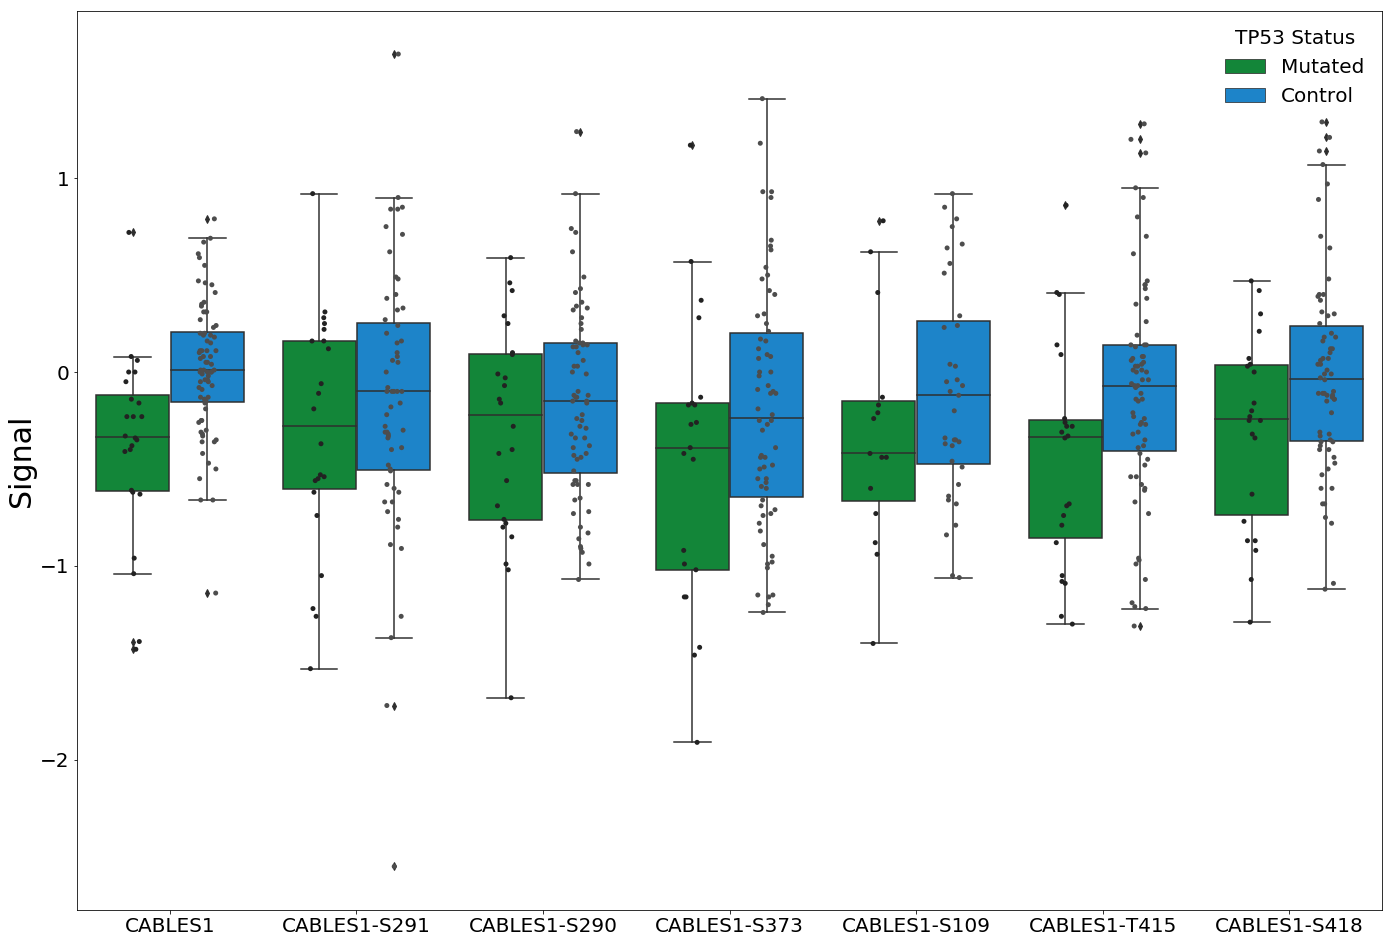

In [82]:
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutated": "#009933", "Control": "#008ae6"}

#Create the plot
boxplt = sns.boxplot(x='Type', y='Reading', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y='Reading', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutated', 'Control'], title='TP53 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
#boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
fig.savefig('p53_cis.png', dpi=300)
plt.show()

## TP53 and HSP90AB1

### Retrieve the data and build dataframe for plotting

In [83]:
protein = 'HSP90AB1'
proteomicsdf = CPTAC.compare_mutations(proteomics, protein, gene)
proteomicsdf = proteomicsdf.loc[proteomicsdf['Patient_Type'] == 'Tumor'][[protein]]

In [84]:
phosdf = CPTAC.compare_mutations(phos, protein, gene)
phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis=1)

In [85]:
plotdf = proteomicsdf.join(phosdf)
plotdf.loc[(plotdf['Mutation'] == "Wildtype"), "Mutation"] = "Control"
plotdf.loc[(plotdf['Mutation'] != "Control"), "Mutation"] = "Mutated"

plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Type', value_name='Reading')
plotdf = plotdf.loc[(plotdf["Mutation"] == "Control") | (plotdf["Mutation"] == "Mutated")]
plotdf = plotdf.dropna(axis=0).sort_values(by=['Mutation'], ascending=False)

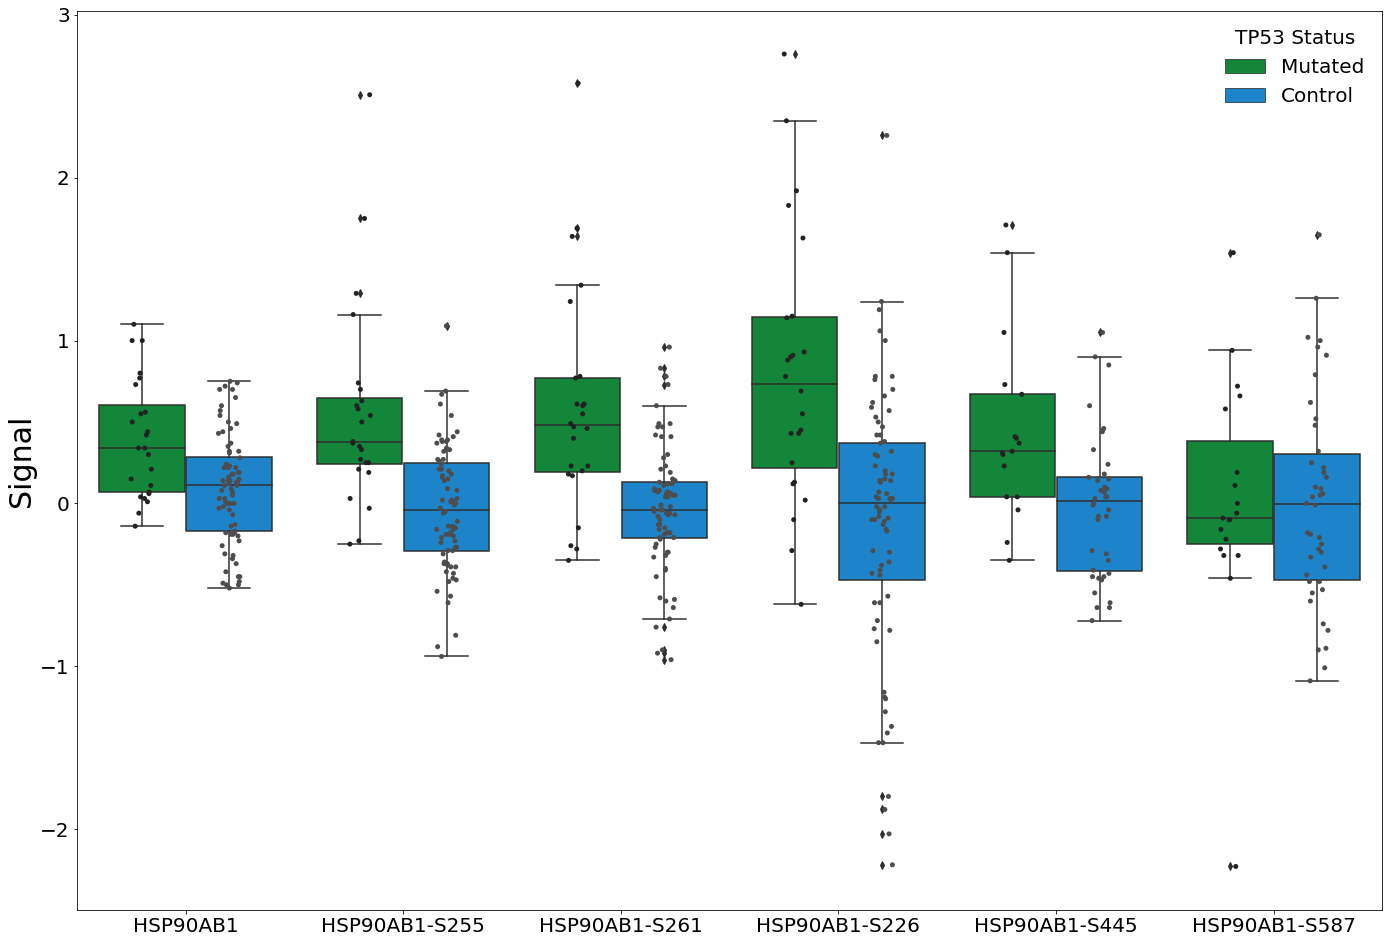

In [86]:
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutated": "#009933", "Control": "#008ae6"}

#Create the plot
boxplt = sns.boxplot(x='Type', y='Reading', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y='Reading', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutated', 'Control'], title='TP53 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
#boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
fig.savefig('p53_cis.png', dpi=300)
plt.show()

# TP53 and TAF1

### Retrieve the data and build dataframe for plotting

In [87]:
protein = 'TAF1'
proteomicsdf = CPTAC.compare_mutations(proteomics, protein, gene)
proteomicsdf = proteomicsdf.loc[proteomicsdf['Patient_Type'] == 'Tumor'][[protein]]

In [88]:
phosdf = CPTAC.compare_mutations(phos, protein, gene)
phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis=1)

In [89]:
plotdf = proteomicsdf.join(phosdf)
plotdf.loc[(plotdf['Mutation'] == "Wildtype"), "Mutation"] = "Control"
plotdf.loc[(plotdf['Mutation'] != "Control"), "Mutation"] = "Mutated"

plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Type', value_name='Reading')
plotdf = plotdf.loc[(plotdf["Mutation"] == "Control") | (plotdf["Mutation"] == "Mutated")]
plotdf = plotdf.dropna(axis=0).sort_values(by=['Mutation'], ascending=False)

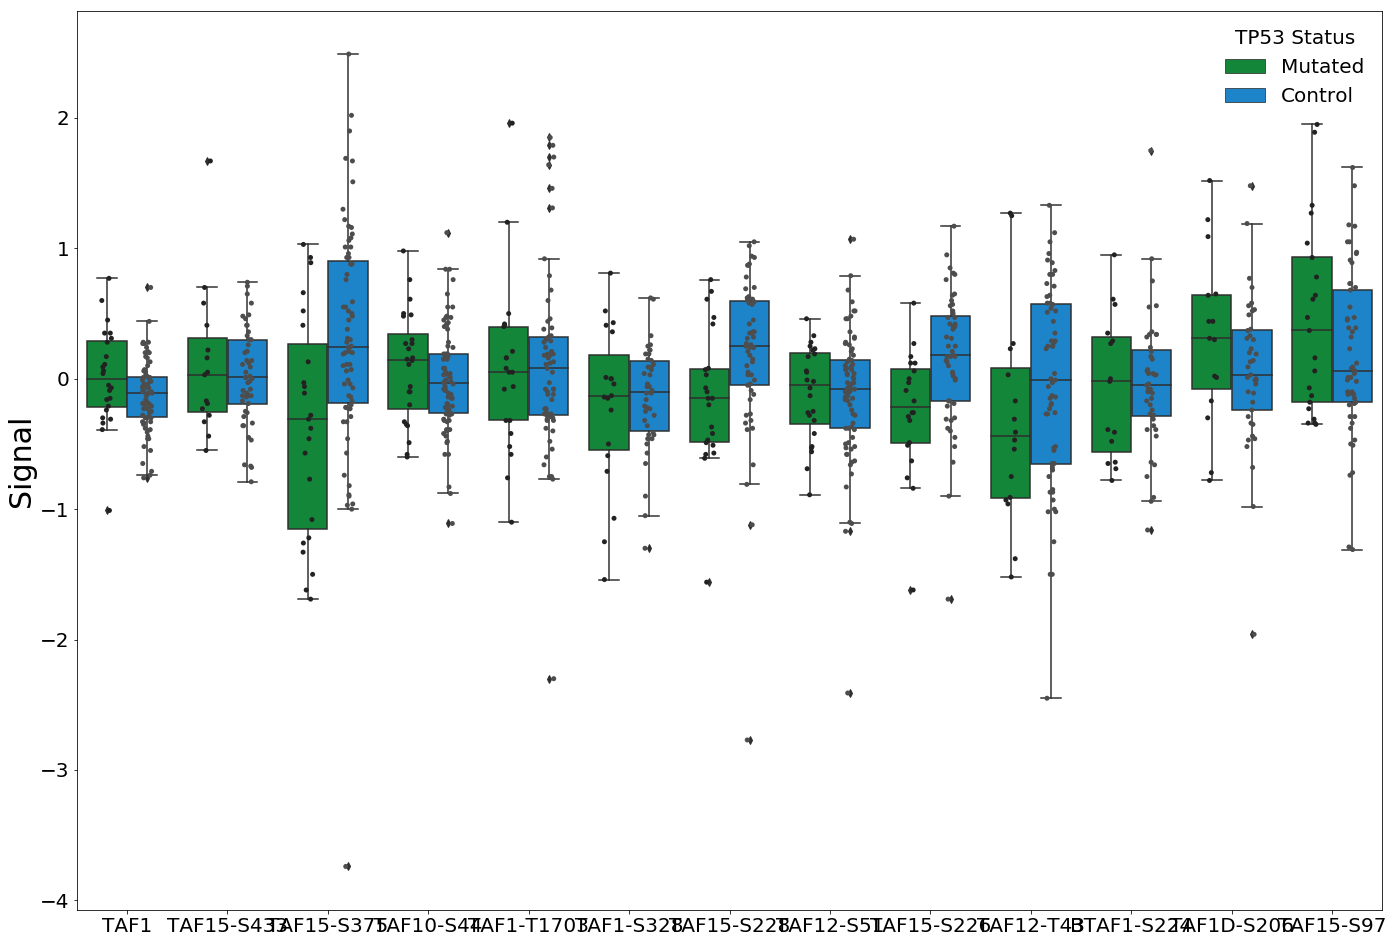

In [90]:
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutated": "#009933", "Control": "#008ae6"}

#Create the plot
boxplt = sns.boxplot(x='Type', y='Reading', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y='Reading', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutated', 'Control'], title='TP53 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
#boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
fig.savefig('p53_cis.png', dpi=300)
plt.show()

## TP53 and CHD8

### Retrieve the data and build dataframe for plotting

In [91]:
protein = 'CHD8'
proteomicsdf = CPTAC.compare_mutations(proteomics, protein, gene)
proteomicsdf = proteomicsdf.loc[proteomicsdf['Patient_Type'] == 'Tumor'][[protein]]

In [92]:
phosdf = CPTAC.compare_mutations(phos, protein, gene)
phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis=1)

In [93]:
plotdf = proteomicsdf.join(phosdf)
plotdf.loc[(plotdf['Mutation'] == "Wildtype"), "Mutation"] = "Control"
plotdf.loc[(plotdf['Mutation'] != "Control"), "Mutation"] = "Mutated"

plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Type', value_name='Reading')
plotdf = plotdf.loc[(plotdf["Mutation"] == "Control") | (plotdf["Mutation"] == "Mutated")]
plotdf = plotdf.dropna(axis=0).sort_values(by=['Mutation'], ascending=False)

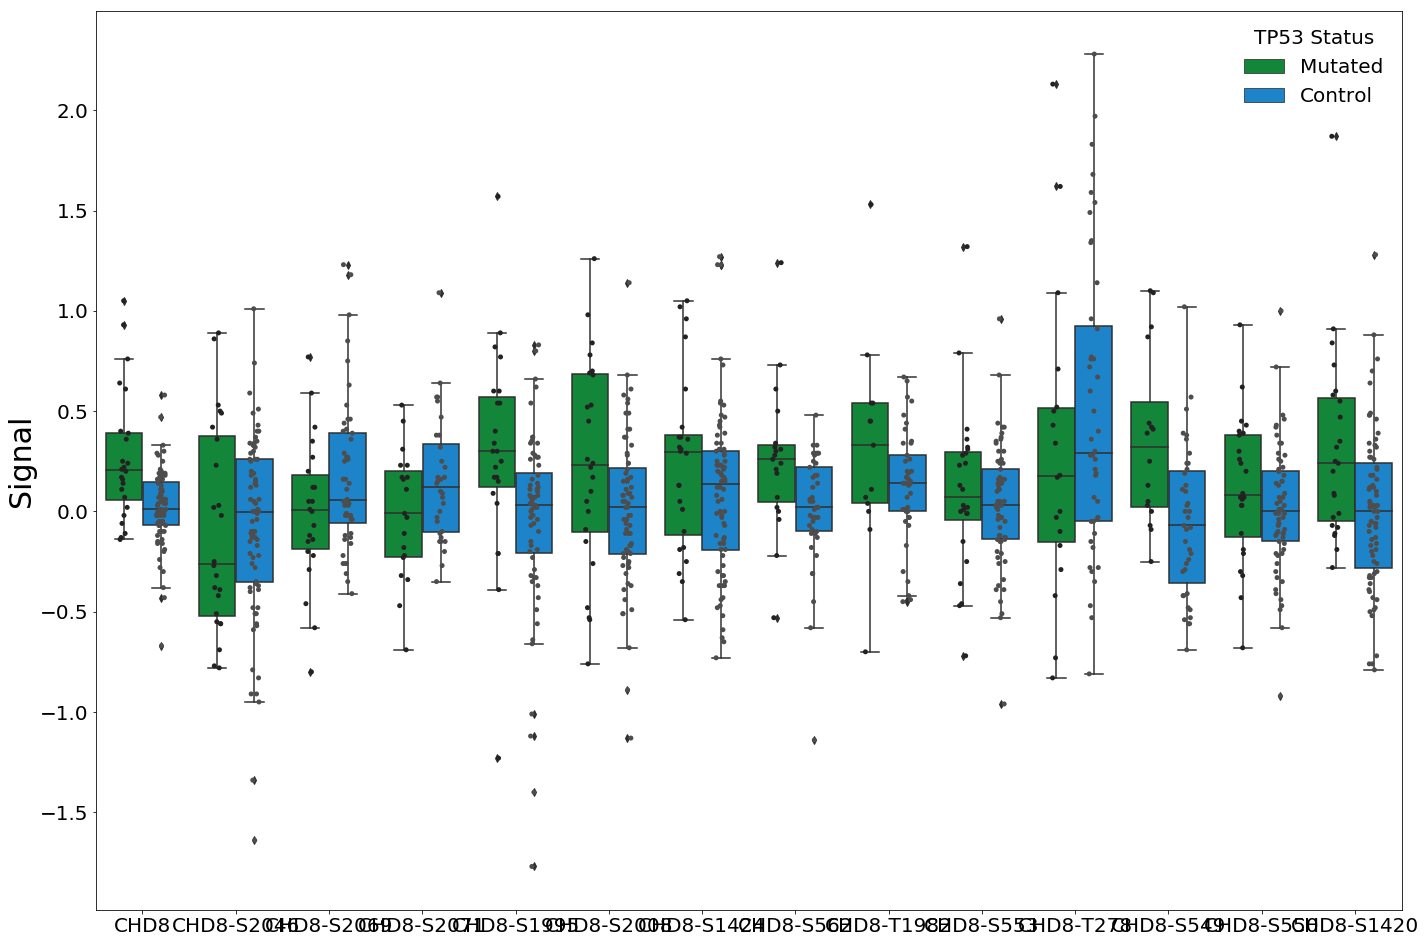

In [94]:
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutated": "#009933", "Control": "#008ae6"}

#Create the plot
boxplt = sns.boxplot(x='Type', y='Reading', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y='Reading', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutated', 'Control'], title='TP53 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
#boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
fig.savefig('p53_cis.png', dpi=300)
plt.show()

## TP53 and CDKN2AIP

### Retrieve the data and build dataframe for plotting

In [95]:
protein = 'CDKN2AIP'
proteomicsdf = CPTAC.compare_mutations(proteomics, protein, gene)
proteomicsdf = proteomicsdf.loc[proteomicsdf['Patient_Type'] == 'Tumor'][[protein]]

In [96]:
phosdf = CPTAC.compare_mutations(phos, protein, gene)
phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis=1)

In [97]:
plotdf = proteomicsdf.join(phosdf)
plotdf.loc[(plotdf['Mutation'] == "Wildtype"), "Mutation"] = "Control"
plotdf.loc[(plotdf['Mutation'] != "Control"), "Mutation"] = "Mutated"

plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Type', value_name='Reading')
plotdf = plotdf.loc[(plotdf["Mutation"] == "Control") | (plotdf["Mutation"] == "Mutated")]
plotdf = plotdf.dropna(axis=0).sort_values(by=['Mutation'], ascending=False)

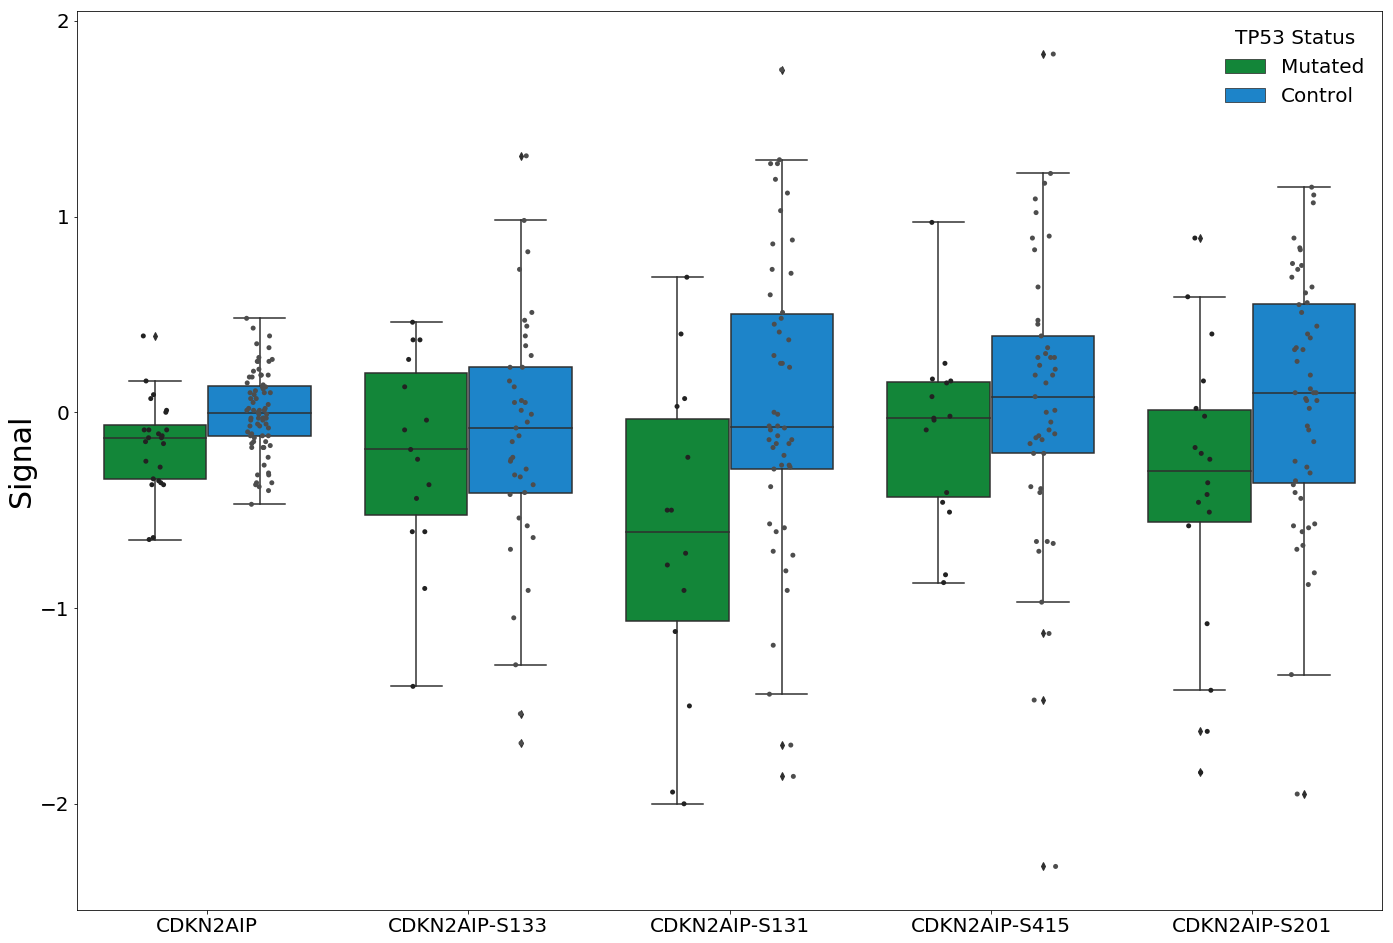

In [98]:
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutated": "#009933", "Control": "#008ae6"}

#Create the plot
boxplt = sns.boxplot(x='Type', y='Reading', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y='Reading', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutated', 'Control'], title='TP53 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
#boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
fig.savefig('p53_cis.png', dpi=300)
plt.show()

## TP53 and YWHAZ

### Retrieve the data and build dataframe for plotting

In [99]:
protein = 'YWHAZ'
proteomicsdf = CPTAC.compare_mutations(proteomics, protein, gene)
proteomicsdf = proteomicsdf.loc[proteomicsdf['Patient_Type'] == 'Tumor'][[protein]]

In [100]:
phosdf = CPTAC.compare_mutations(phos, protein, gene)
phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis=1)

In [101]:
plotdf = proteomicsdf.join(phosdf)
plotdf.loc[(plotdf['Mutation'] == "Wildtype"), "Mutation"] = "Control"
plotdf.loc[(plotdf['Mutation'] != "Control"), "Mutation"] = "Mutated"

plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Type', value_name='Reading')
plotdf = plotdf.loc[(plotdf["Mutation"] == "Control") | (plotdf["Mutation"] == "Mutated")]
plotdf = plotdf.dropna(axis=0).sort_values(by=['Mutation'], ascending=False)

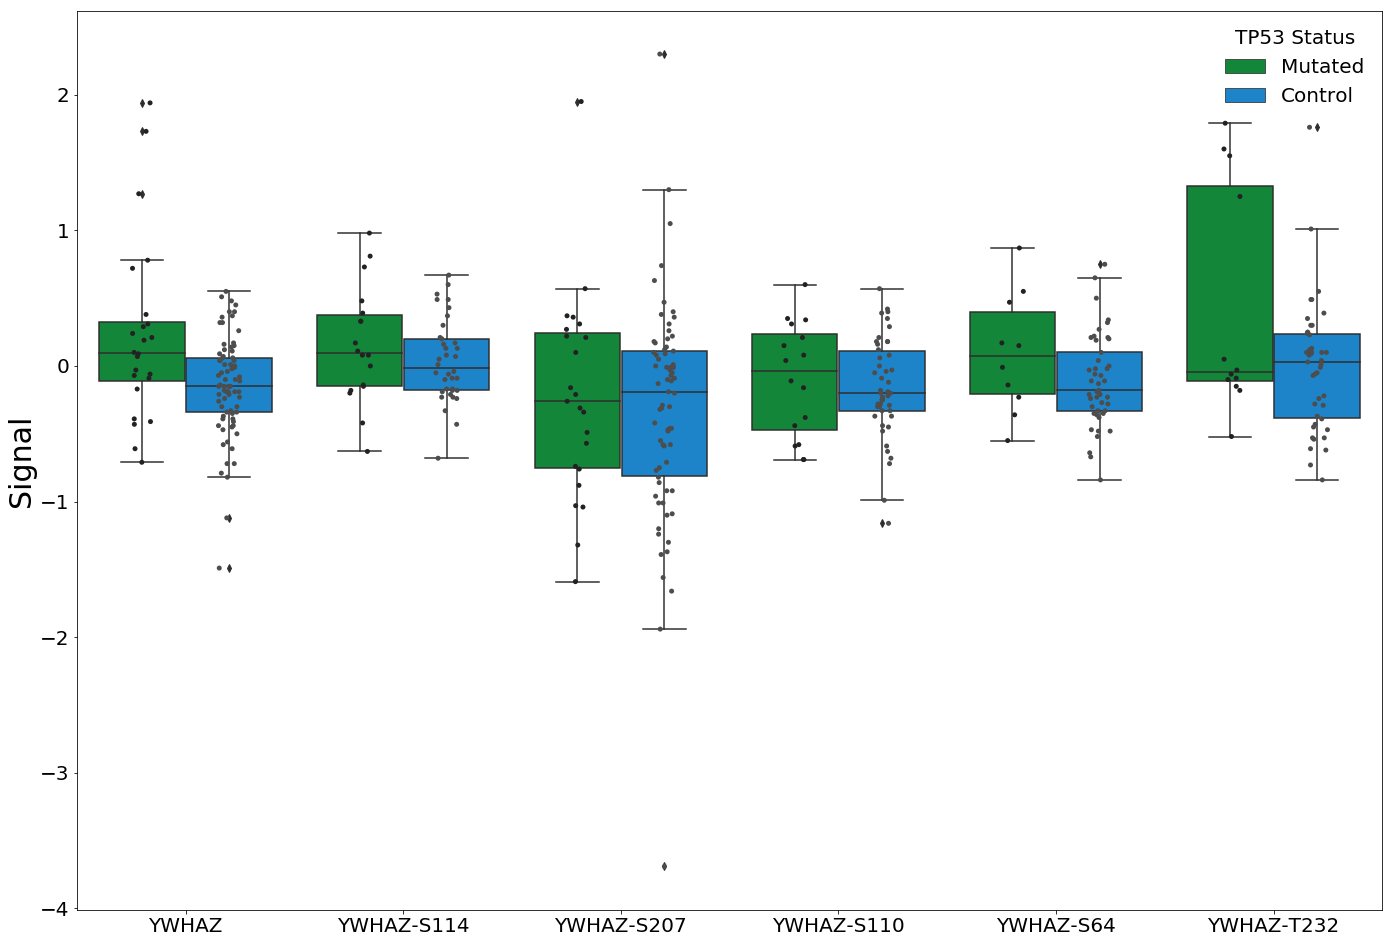

In [102]:
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutated": "#009933", "Control": "#008ae6"}

#Create the plot
boxplt = sns.boxplot(x='Type', y='Reading', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y='Reading', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutated', 'Control'], title='TP53 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
#boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
fig.savefig('p53_cis.png', dpi=300)
plt.show()

## TP53 and AURKA *no phosphoproteomics data

### Retrieve the data and build dataframe for plotting

In [103]:
protein = 'AURKA'
proteomicsdf = CPTAC.compare_mutations(proteomics, protein, gene)
plotdf = proteomicsdf.loc[proteomicsdf['Patient_Type'] == 'Tumor'][[protein, 'Mutation']]

In [104]:
plotdf.loc[(plotdf['Mutation'] == "Wildtype"), "Mutation"] = "Control"
plotdf.loc[(plotdf['Mutation'] != "Control"), "Mutation"] = "Mutated"
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Type', value_name='Reading')
plotdf = plotdf.loc[(plotdf["Mutation"] == "Control") | (plotdf["Mutation"] == "Mutated")]
plotdf = plotdf.dropna(axis=0).sort_values(by=['Mutation'], ascending=False)

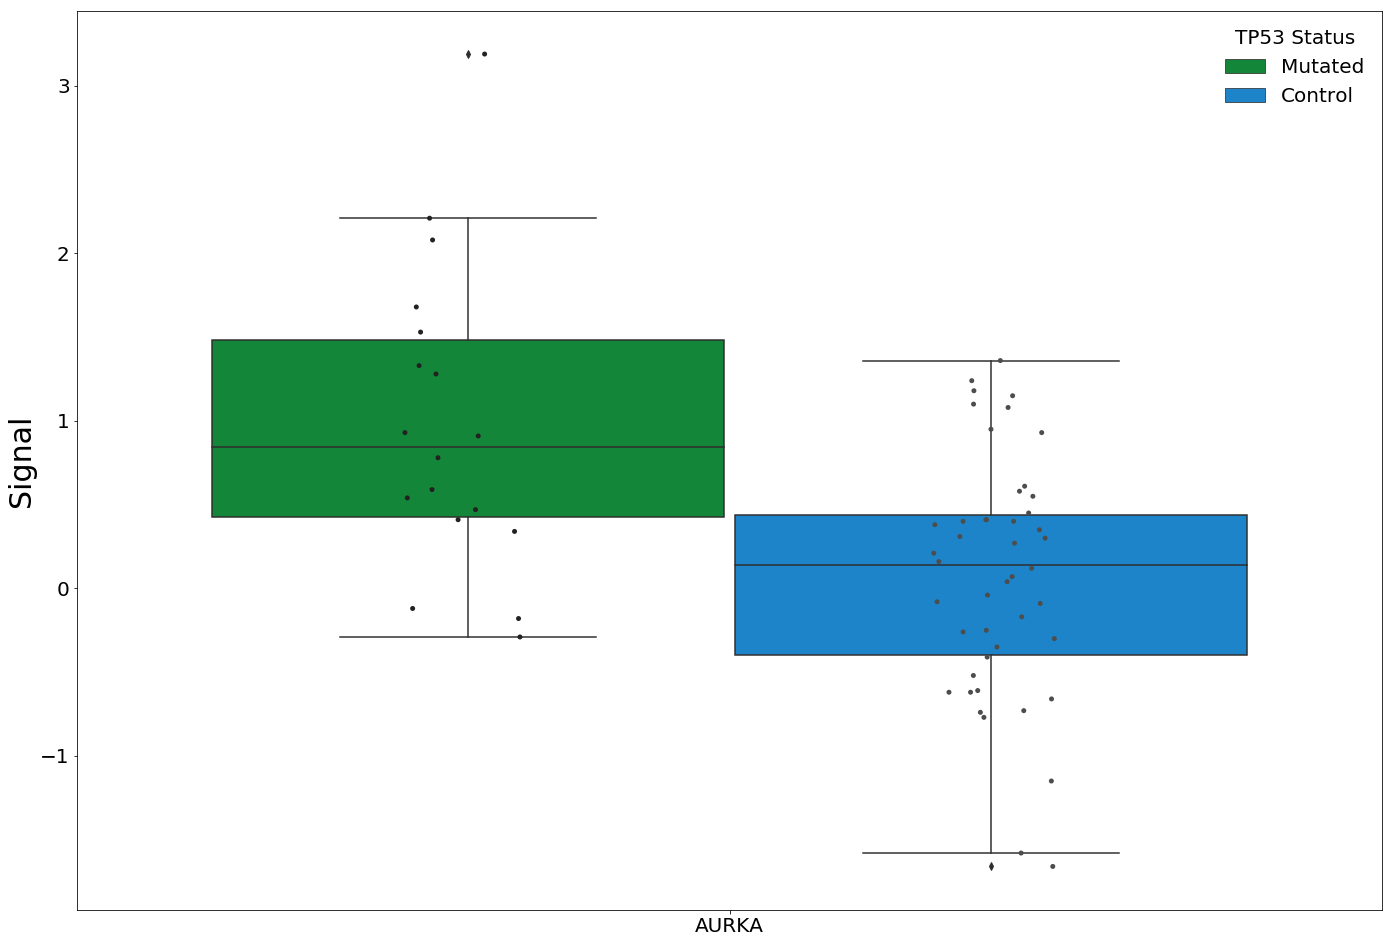

In [105]:
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutated": "#009933", "Control": "#008ae6"}

#Create the plot
boxplt = sns.boxplot(x='Type', y='Reading', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y='Reading', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutated', 'Control'], title='TP53 Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
#boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
fig.savefig('p53_cis.png', dpi=300)
plt.show()